In [1]:
import galprime as gp
gp.plotting.pyplot_style()

from astropy.io import fits

import numpy as np

from scipy.special import gamma

from matplotlib import pyplot as plt

from astropy.visualization import ZScaleInterval

from photutils.background import Background2D

In [2]:
sim = gp.GPrime()


yass


In [3]:
cutouts = gp.Cutouts.from_file("../pdata/cutouts_i.fits", verbose=True)

Loaded 50 cutouts from ../pdata/cutouts_i.fits


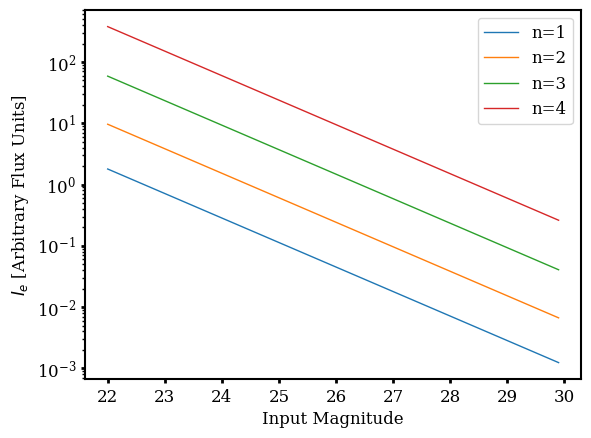

In [5]:

mags = np.arange(22, 30, 0.1)

for n in [1, 2, 3, 4]:
    plt.plot(mags, gp.I_e(mags, 5, n), label=f"n={n}")

plt.xlabel("Input Magnitude")
plt.ylabel(r"$I_e$" + f' [Arbitrary Flux Units]')
plt.yscale("log")
plt.legend()
plt.show()

